**MIRI/MRS Pipeline Script applied to Uranus Cubes**

Based heavily on notebooks by Patrick Kavanagh (DIAS, Ireland): https://github.com/PaddyKavanagh/build7.2.1_notebooks/blob/master/MRS_pipeline.ipynb

* Installed from instructions on https://github.com/spacetelescope/jwst
* `conda create -n jwst_test python`
* `conda activate jwst_test`
* `pip install jwst`
* <code>export CRDS_PATH=$HOME/crds_cache</code>
* <code>export CRDS_SERVER_URL=https://jwst-crds.stsci.edu</code>
* Execution of the level 2A, 2B, and 3 pipelines for MRS data in Python.
* `source activate jwst_test` before opening this notebook.

The steps applied are:
* Ramps to slopes pipeline (Detector1Pipeline)
* CALSPEC2 steps and spectral extraction from each dither (Spec2Pipeline)
* Combination of dithers and spectral extraction (Spec3Pipeline)
* Manual conversion of extracted spectra to Jy

In [1]:
# Imports

import os, glob, shutil

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call

from jwst import datamodels

# set the CRDS_CONTEXT for the correct build (here 0.18.1)
os.environ["CRDS_CONTEXT"] = "jwst_0664.pmap"
os.environ["CRDS_PATH"] = "/Users/lnf2/crds_cache"


%matplotlib inline
# %matplotlib notebook # if you want interactive plots

**Set input, output location and source type**

Since we know the simulation is of a point source, we can set the source type metadata to 'POINT' at this stage as that information is used later in spectral extraction. Otherwise, the pipeline will set the default source type for MRS which is 'EXTENDED'

In [2]:
# set input filenames and directory. In this example, the files are located in a folder called 'testdir'

input_dir = 'MIRIUranus_LONG/det_images'
input_files = glob.glob(os.path.join(input_dir,'*.fits'))

# set the source type as 'POINT'
for f in input_files:
    with datamodels.MIRIRampModel(f) as dm:
        dm.meta.target.source_type = 'EXTENDED'
        dm.save(os.path.join(input_dir, dm.meta.filename))

# set the output directory name
output_dir = input_dir + '_pipelined'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

/opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/jwst/lib/basic_utils.py:24: DeprecationWarning: "MIRIRampModel" is deprecated and will be removed. Use RampModel
  warnings.warn(message.format(old_class=old_class.__name__, new_class=new_class.__name__),
/opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/jwst/lib/basic_utils.py:24: DeprecationWarning: "MIRIRampModel" is deprecated and will be removed. Use RampModel
  warnings.warn(message.format(old_class=old_class.__name__, new_class=new_class.__name__),


Print some information about the input files. We will just look at the first file


In [3]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:

    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['DETECTOR']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t\t\t\t Detector\t nInts\t nGrps\t rdPatt\t subAr\t chan.\t band")
        print("--------------------------------------------------------------------------------------------------")
        print("%s\t %s\t %d\t %s\t %s\t %s\t %s\t %s" % (identifier,detector,nInts,nGroups,readPatt,subArr,channel,band))
        print("\n\n")

    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['DETECTOR']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t Detector\t nInts\t nGrps\t rdPatt\t chan.\t band")
        print("--------------------------------------------------------------------------------------------------")
        print("MIRISim\t %s\t %d\t %s\t %s\t %s\t %s" % (detector,nInts,nGroups,readPatt,channel,band))
        print("\n\n")

    # fits extension table
    hdulist.info()


ID	 Detector	 nInts	 nGrps	 rdPatt	 chan.	 band
--------------------------------------------------------------------------------------------------
MIRISim	 MIRIFULONG	 3	 10	 FAST	 34	 LONG



Filename: MIRIUranus_LONG/det_images/det_image_seq1_MIRIFULONG_34LONGexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     110   ()      
  1  SCI           1 ImageHDU        49   (1032, 1024, 10, 3)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (1032, 1024, 10, 3)   uint8   
  4  ERR           1 ImageHDU        11   (1032, 1024, 10, 3)   float32   
  5  REFOUT        1 ImageHDU        11   (258, 1024, 10, 3)   float32   
  6  ASDF          1 BinTableHDU     11   1R x 1C   [6896B]   


/opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Show the last frame of the first integration for each file


/opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/jwst/lib/basic_utils.py:24: DeprecationWarning: "MIRIRampModel" is deprecated and will be removed. Use RampModel
  warnings.warn(message.format(old_class=old_class.__name__, new_class=new_class.__name__),
/opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/jwst/lib/basic_utils.py:24: DeprecationWarning: "MIRIRampModel" is deprecated and will be removed. Use RampModel
  warnings.warn(message.format(old_class=old_class.__name__, new_class=new_class.__name__),


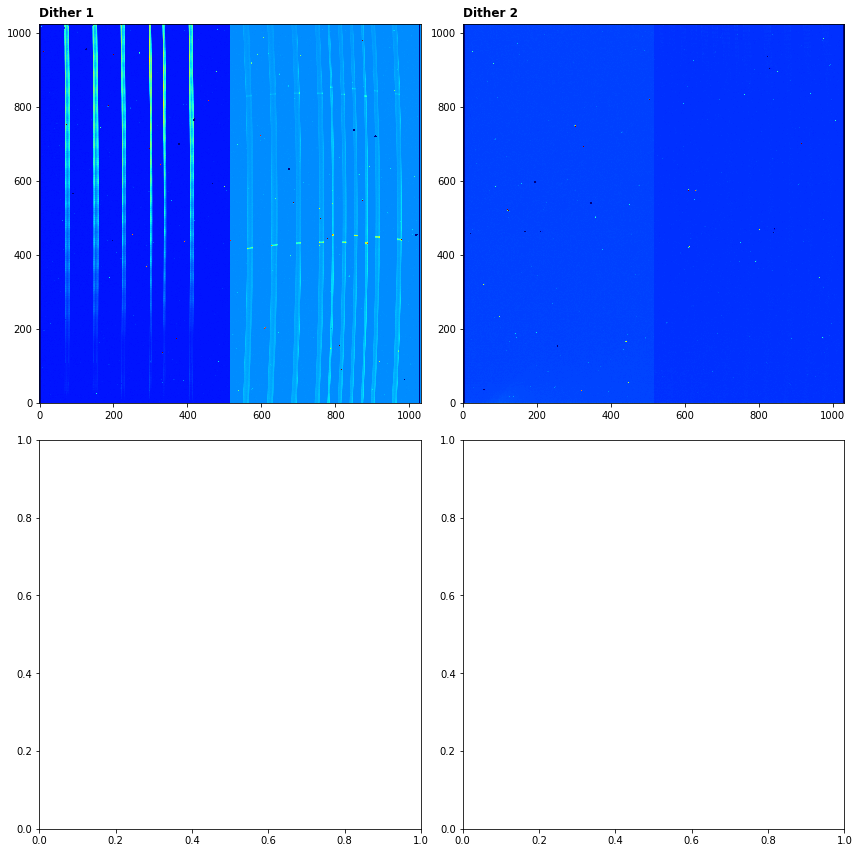

In [4]:

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()

i = 0
for f in input_files:
    # open the input image as a jwst data model
    with datamodels.MIRIRampModel(f) as in_dm:

        dith_num = i+1
        axs[i].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=1.5e4))
        axs[i].annotate('Dither %d' % dith_num, xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[i].set_facecolor('black')
        i += 1

plt.tight_layout()
plt.show()

## Level 2A pipeline (ramps-to-slopes)
Import the level 2A pipeline class and print description.
The output level 2A files will be saved in the output_dir as '*_rate.fits'

In [5]:
#LEVEL 2A PIPELINE

from jwst.pipeline import Detector1Pipeline
print(Detector1Pipeline.__doc__)

for f in input_files:
    Detector1Pipeline.call(f, output_use_model=True, save_results=True, output_dir=output_dir,
                           steps={'ipc': {'skip': True},
                                  'dark_current': {'skip': True},
                                  'refpix': {'skip': True}})


/opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-03-04 15:40:48,404 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/jwst/lib/basic_utils.py:24: DeprecationWarning: "MIRIRampModel" is deprecated and will be removed. Use RampModel
  warnings.warn(message.format(old_class=old_class.__name__, new_class=new_class.__name__),




    Detector1Pipeline: Apply all calibration steps to raw JWST
    ramps to produce a 2-D slope product. Included steps are:
    group_scale, dq_init, saturation, ipc, superbias, refpix, rscd,
    lastframe, linearity, dark_current, persistence, jump detection,
    ramp_fit, and gain_scale.
    


2021-03-04 15:40:48,607 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/jwst/lib/basic_utils.py:24: DeprecationWarning: "MIRIRampModel" is deprecated and will be removed. Use RampModel
  warnings.warn(message.format(old_class=old_class.__name__, new_class=new_class.__name__),

2021-03-04 15:40:52,039 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/jwst/lib/basic_utils.py:24: DeprecationWarning: "MIRIRampModel" is deprecated and will be removed. Use RampModel
  warnings.warn(message.format(old_class=old_class.__name__, new_class=new_class.__name__),

2021-03-04 15:40:52,052 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/jwst/lib/basic_utils.py:24: DeprecationWarning: "MIRIRampModel" is deprecated and will be removed. Use RampModel
  warnings.warn(message.format(old_class=old_class.__name__, new_class=new_class.__name__),

2021-03-04 15:40:52,065 - stpipe - WARNING - /opt/anaconda3/envs/jwst_tes

2021-03-04 15:40:52,444 - stpipe.Detector1Pipeline - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/jwst/lib/basic_utils.py:24: DeprecationWarning: "MIRIRampModel" is deprecated and will be removed. Use RampModel
  warnings.warn(message.format(old_class=old_class.__name__, new_class=new_class.__name__),

2021-03-04 15:40:52,577 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34LONGexp1.fits' reftypes = ['gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2021-03-04 15:40:52,601 - CRDS - INFO -  Fetching  /Users/lnf2/crds_cache/references/jwst/miri/jwst_miri_linearity_0022.fits   46.5 M bytes  (1 / 1 files) (0 / 46.5 M bytes)
2021-03-04 15:41:05,194 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/lnf2/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2021-03-04 15:41:05,195 - stpipe.Detector1Pipeline 

2021-03-04 15:41:07,777 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'MIRIUranus_LONG/det_images'}
2021-03-04 15:41:07,797 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/lnf2/crds_cache/references/jwst/miri/jwst_miri_linearity_0022.fits
2021-03-04 15:41:08,226 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-03-04 15:41:08,343 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).
2021-03-04 15:41:08,345 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext':

2021-03-04 15:41:51,284 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': 'MIRIUranus_LONG/det_images'}
2021-03-04 15:41:51,308 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2021-03-04 15:41:51,309 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2021-03-04 15:41:51,311 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2021-03-04 15:41:51,582 - stpipe.Detector1Pipeline - INFO - Saved model in MIRIUranus_LONG/det_images_pipelined/det_image_seq1_MIRIFULONG_34LONGexp1_rateints.fits
2021-03-04 15:41:51,583 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2021-03-04 15:41:51,741 - stpipe.Detector1Pipeline - INFO 

2021-03-04 15:41:52,356 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'MIRIUranus_LONG/det_images_pipelined', 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks'

2021-03-04 15:41:52,831 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped
2021-03-04 15:41:52,832 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done
2021-03-04 15:41:52,896 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).
2021-03-04 15:41:52,898 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'MIRIUranus_LONG/det_images'}
2021-03-04 15:41:52,914 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /Users/lnf2/crds_cache/references/jwst/miri/jwst_miri_mask_0022.fits
2021-03-04 15:41:53,152 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done
2021-03

2021-03-04 15:41:55,565 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'MIRIUranus_LONG/det_images', 'rejection_threshold': 4.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}
2021-03-04 15:41:55,575 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2021-03-04 15:41:55,579 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/lnf2/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits
2021-03-04 15:41:55,594 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/lnf2/crds_cache/references/jwst/miri/jwst_miri_readnoise_0060.fits
2021-03-04 15:41:55,610 - stpipe.Detector1Pipelin

In [6]:
# Quick check of the pipeline steps applied in the output. We'll look at the first dither:
level2A_files = glob.glob(os.path.join(output_dir,'*_rate.fits'))

with datamodels.open(level2A_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('dq_init: %s' % dm.meta.cal_step.dq_init)
    print('saturation: %s' % dm.meta.cal_step.saturation)
    print('ipc: %s' % dm.meta.cal_step.ipc)
    print('linearity: %s' % dm.meta.cal_step.linearity)
    print('rscd: %s' % dm.meta.cal_step.rscd)
    print('firstframe: %s' % dm.meta.cal_step.firstframe)
    print('lastframe: %s' % dm.meta.cal_step.lastframe)
    print('dark_current: %s' % dm.meta.cal_step.dark_sub)
    print('refpix: %s' % dm.meta.cal_step.refpix)
    print('jump: %s' % dm.meta.cal_step.jump)
    print('ramp_fit: %s' % dm.meta.cal_step.ramp_fit)

2021-03-04 15:45:03,956 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Check step information status:
dq_init: COMPLETE
saturation: COMPLETE
ipc: None
linearity: COMPLETE
rscd: COMPLETE
firstframe: COMPLETE
lastframe: COMPLETE
dark_current: None
refpix: None
jump: COMPLETE
ramp_fit: COMPLETE


## Level 2B pipeline
import the level 2B pipeline class and print description.
We pass the level 2A files. The output level 2B files will be saved in the output_dir as '*_cal.fits'.
Note that since MIRISim does not add straylight, we can skip the straylight correction step.

The level 2B pipeline for the MRS produces three files for each input:
* _cal.fits - the calibrated level 2B file from each dither
* _s3d.fits - the cube from each dither
* _x1d.fits - the 1d spectrum from each dither

In [7]:
from jwst.pipeline import Spec2Pipeline
print(Spec2Pipeline.__doc__)

for f in level2A_files:
    Spec2Pipeline.call(f, output_use_model=True, save_results=True, output_dir=output_dir, 
                       steps={'straylight':{'skip':True}})

2021-03-04 15:45:10,491 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)




    Spec2Pipeline: Processes JWST spectroscopic exposures from Level 2a to 2b.
    Accepts a single exposure or an association as input.

    Included steps are:
    assign_wcs, background subtraction, NIRSpec MSA imprint subtraction,
    NIRSpec MSA bad shutter flagging, 2-D subwindow extraction, flat field,
    source type decision, straylight, fringe, pathloss, barshadow,  photom,
    resample_spec, cube_build, and extract_1d.
    


2021-03-04 15:45:10,834 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-03-04 15:45:10,835 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-03-04 15:45:10,837 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-03-04 15:45:10,838 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-03-04 15:45:10,840 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2021-03-04 15:45:10,841 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2021-03-04 15:45:10,844 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.
2021-03-04 15:45:10,846 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.
2021-03-04 15:45:10,847 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.
2021-03-04 15:45:10,850 - stpipe.Spec2Pipeline.master_

2021-03-04 15:45:11,143 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'resol', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-03-04 15:45:11,148 - CRDS - INFO -  Fetching  /Users/lnf2/crds_cache/references/jwst/miri/jwst_miri_distortion_0029.asdf  131.1 K bytes  (1 / 6 files) (0 / 144.0 M bytes)
2021-03-04 15:45:14,740 - CRDS - INFO -  Fetching  /Users/lnf2/crds_cache/references/jwst/miri/jwst_miri_flat_0543.fits   21.2 M bytes  (2 / 6 files) (131.1 K / 144.0 M bytes)
2021-03-04 15:45:32,255 - CRDS - INFO -  Fetching  /Users/lnf2/crds_cache/references/jwst/miri/jwst_miri_fringe_0049.fits   12.7 M bytes  (3

2021-03-04 15:46:57,143 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2021-03-04 15:46:57,144 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2021-03-04 15:46:57,231 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>, []).
2021-03-04 15:46:57,233 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': 'MIRIUranus_LONG/det_images_pipelined'}
2021-03-04 15:46:57,233 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2021-03-04 15:46:57,235 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2021-03-04 15:46:57,320 - stpipe.Spec2P

2021-03-04 15:47:01,976 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2021-03-04 15:47:01,976 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT
2021-03-04 15:47:01,977 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS
2021-03-04 15:47:01,977 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG
2021-03-04 15:47:02,052 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2021-03-04 15:47:02,064 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2021-03-04 15:47:02,272 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from MIRIUranus_LONG/det_images_pipelined/det_image_seq1_MIRIFUSHORT_12LONGexp1_cal.fits>,).
2021-03-04 15:47:02,274 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_mode

2021-03-04 15:57:34,130 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.
2021-03-04 15:57:34,131 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.
2021-03-04 15:57:34,132 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.
2021-03-04 15:57:34,134 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2021-03-04 15:57:34,137 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.
2021-03-04 15:57:34,138 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.
2021-03-04 15:57:34,139 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.
2021-03-04 15:57:34,141 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.
2021-03-04 15:57:34,143 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.
2021-03-04 15:57:34,144 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.
2021

2021-03-04 15:57:34,381 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'resol', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-03-04 15:57:34,387 - CRDS - INFO -  Fetching  /Users/lnf2/crds_cache/references/jwst/miri/jwst_miri_distortion_0032.asdf   98.3 K bytes  (1 / 6 files) (0 / 143.9 M bytes)
2021-03-04 15:57:36,776 - CRDS - INFO -  Fetching  /Users/lnf2/crds_cache/references/jwst/miri/jwst_miri_flat_0541.fits   21.2 M bytes  (2 / 6 files) (98.3 K / 143.9 M bytes)
2021-03-04 15:57:52,921 - CRDS - INFO -  Fetching  /Users/lnf2/crds_cache/references/jwst/miri/jwst_miri_fringe_0045.fits   12.7 M bytes  (3 /

2021-03-04 15:59:01,300 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2021-03-04 15:59:01,301 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2021-03-04 15:59:01,386 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>, []).
2021-03-04 15:59:01,387 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': 'MIRIUranus_LONG/det_images_pipelined'}
2021-03-04 15:59:01,387 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2021-03-04 15:59:01,388 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2021-03-04 15:59:01,469 - stpipe.Spec2Pi

2021-03-04 15:59:05,321 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2021-03-04 15:59:05,321 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG
2021-03-04 15:59:05,322 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS
2021-03-04 15:59:05,322 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG
2021-03-04 15:59:05,376 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2021-03-04 15:59:05,388 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2021-03-04 15:59:05,572 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from MIRIUranus_LONG/det_images_pipelined/det_image_seq1_MIRIFULONG_34LONGexp1_cal.fits>,).
2021-03-04 15:59:05,575 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model'

In [8]:
# check of output

# set the output file names
level2B_files = glob.glob(os.path.join(output_dir,'*_cal.fits'))
cube_files = glob.glob(os.path.join(output_dir,'*_s3d.fits'))

with datamodels.open(level2B_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('assign_wcs: %s' % dm.meta.cal_step.assign_wcs)
    print('flat_field: %s' % dm.meta.cal_step.flat_field)
    print('srctype: %s' % dm.meta.cal_step.srctype)
    print('straylight: %s' % dm.meta.cal_step.straylight)
    print('fringe: %s' % dm.meta.cal_step.fringe)
    print('photom: %s' % dm.meta.cal_step.photom)

2021-03-04 17:30:23,124 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Check step information status:
assign_wcs: COMPLETE
flat_field: COMPLETE
srctype: COMPLETE
straylight: None
fringe: COMPLETE
photom: COMPLETE


Look at level 1B and calibrated level 2B image. We'll look at the first dither only.

2021-03-04 17:30:29,083 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2021-03-04 17:30:29,088 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/jwst/lib/basic_utils.py:24: DeprecationWarning: "MIRIRampModel" is deprecated and will be removed. Use RampModel
  warnings.warn(message.format(old_class=old_class.__name__, new_class=new_class.__name__),



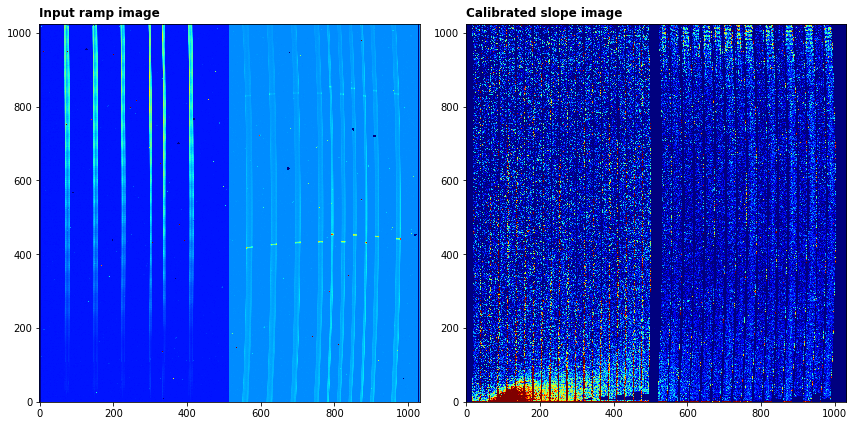

In [9]:
# open the input image as a jwst data model
with datamodels.MIRIRampModel(input_files[0]) as in_dm:
    with datamodels.open(level2B_files[0]) as out_dm:
        
        # plot--------------------------------------
        # show the input ramp image and the calibrated
        # slope image. Note the user may have to adjust
        # the scale parameters
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # sum the groups in the first integration of the input ramp image and plot
        axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=1.5e4))
        axs[0].annotate('Input ramp image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[0].set_facecolor('black')
        axs[1].imshow(out_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=0, vmax=1000)
        axs[1].annotate('Calibrated slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[1].set_facecolor('black')

        plt.tight_layout()
        plt.show()

Look at cube file. We'll look at the first dither only

2021-03-04 17:30:41,382 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



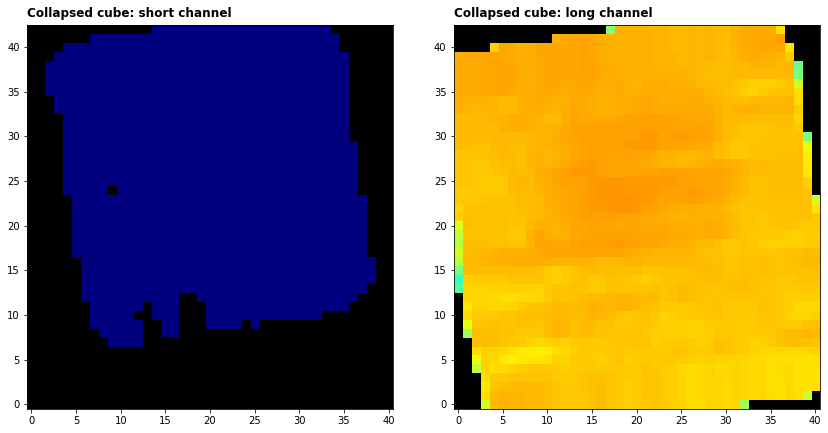

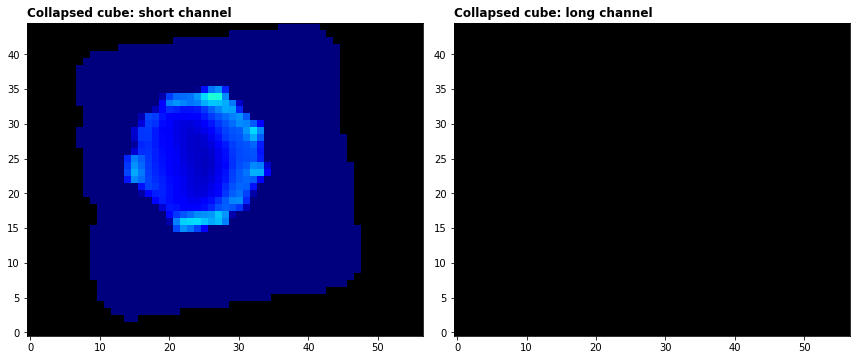

In [10]:
# open the cube as a jwst data model
with datamodels.open(cube_files[0]) as cube_dm:
    
    # plot--------------------------------------
    # sum some of the the frames in each channel
    # Note the user may have to adjust the scaling
    # parameters
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(np.sum(cube_dm.data[100:300], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e5,vmax=1e7))
    axs[0].annotate('Collapsed cube: short channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[0].set_facecolor('black')
    axs[1].imshow(np.sum(cube_dm.data[3000:3200], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1,vmax=1e6))
    axs[1].annotate('Collapsed cube: long channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[1].set_facecolor('black')
    
    plt.tight_layout()
    plt.show()
    
# open the cube as a jwst data model
with datamodels.open(cube_files[1]) as cube_dm:
    
    # plot--------------------------------------
    # sum some of the the frames in each channel
    # Note the user may have to adjust the scaling
    # parameters
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(np.sum(cube_dm.data[100:300], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e5,vmax=1e7))
    axs[0].annotate('Collapsed cube: short channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[0].set_facecolor('black')
    axs[1].imshow(np.sum(cube_dm.data[3000:3200], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1,vmax=1e6))
    axs[1].annotate('Collapsed cube: long channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[1].set_facecolor('black')
    
    plt.tight_layout()
    plt.show()

## Level 3 pipeline
We first create an association file in the output directory containing the list of level 2B files ("_cal.fits") produced by the level 2B pipeline.

Create the level 3 association using the asn_from_list tool

In [11]:
call(["asn_from_list", "-o", "MRS_asn.json"] + level2B_files + ["--product-name", "dither"])


from jwst.pipeline import Spec3Pipeline
print(Spec3Pipeline.__doc__)

# read the association and run
dms = datamodels.open("MRS_asn.json")
Spec3Pipeline.call(dms, save_results=True, output_dir=output_dir,
                  steps={'cube_build': {'save_results': True, 'output_dir': output_dir},
                         'extract_1d': {'save_results': True, 'output_dir': output_dir},
                         'mrs_imatch': {'skip': True}})

2021-03-04 17:30:55,137 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)




    Spec3Pipeline: Processes JWST spectroscopic exposures from Level 2b to 3.

    Included steps are:
    assign moving target wcs (assign_mtwcs)
    master background subtraction (master_background)
    MIRI MRS background matching (mrs_imatch)
    outlier detection (outlier_detection)
    2-D spectroscopic resampling (resample_spec)
    3-D spectroscopic resampling (cube_build)
    1-D spectral extraction (extract_1d)
    1-D spectral combination (combine_1d)
    


2021-03-04 17:31:17,195 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2021-03-04 17:31:17,196 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2021-03-04 17:31:17,198 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2021-03-04 17:31:17,200 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2021-03-04 17:31:17,202 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2021-03-04 17:31:17,204 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2021-03-04 17:31:17,206 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.
2021-03-04 17:31:17,209 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2021-03-04 17:31:17,211 - stpipe.Spec3Pipeline.combine_1d - INFO - Combine1dStep instance created.
2021-03-04 17:31:17,485 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline running

2021-03-04 17:31:17,943 - stpipe.Spec3Pipeline.outlier_detection - INFO - Performing outlier detection on 2 inputs
2021-03-04 17:31:20,035 - stpipe.Spec3Pipeline.outlier_detection - INFO - Performing IFU outlier_detection for exptype MIR_MRS
2021-03-04 17:31:20,037 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.
2021-03-04 17:31:20,037 - stpipe.CubeBuildStep - INFO - Starting IFU Cube Building Step
2021-03-04 17:31:20,038 - stpipe.CubeBuildStep - INFO - Input interpolation: pointcloud
2021-03-04 17:31:20,039 - stpipe.CubeBuildStep - INFO - Coordinate system to use: skyalign
2021-03-04 17:31:20,039 - stpipe.CubeBuildStep - INFO - Weighting method for point cloud: emsm
2021-03-04 17:31:20,040 - stpipe.CubeBuildStep - INFO - Power weighting distance: 2.0
2021-03-04 17:31:20,042 - stpipe.CubeBuildStep - INFO - Cube Type: Single cubes
2021-03-04 17:31:20,067 - stpipe.Spec3Pipeline.outlier_detection - INFO - The desired cubes cover the MIRI Channels: ['4']
2021-03-04 17:31:20

2021-03-04 17:34:51,505 - stpipe.Spec3Pipeline.outlier_detection - INFO - Single = true, creating a set of single exposures mapped to output IFUCube coordinate system
2021-03-04 17:34:51,807 - stpipe.Spec3Pipeline.outlier_detection - INFO - Cube Geometry:
2021-03-04 17:34:51,808 - stpipe.Spec3Pipeline.outlier_detection - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)
2021-03-04 17:34:51,808 - stpipe.Spec3Pipeline.outlier_detection - INFO - Axis 1    33  17.00   0.00000419   0.13000000  -2.14499992   2.14499992
2021-03-04 17:34:51,809 - stpipe.Spec3Pipeline.outlier_detection - INFO - Axis 2    35  18.00  -0.00000426   0.13000000  -2.27499992   2.27499992
2021-03-04 17:34:51,809 - stpipe.Spec3Pipeline.outlier_detection - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)
2021-03-04 17:34:51,810 - stpipe.Spec3Pipeline.outlier_detection - INFO - Axis 3  1091   1.00   6.42050008   0.00100000   6.42000008   7.51100013
2021-03-04 1

2021-03-04 17:37:59,650 - stpipe.Spec3Pipeline.cube_build - INFO - Output Cubes are single channel, single sub-channel IFU Cubes
2021-03-04 17:37:59,651 - stpipe.Spec3Pipeline.cube_build - INFO - Number of IFU cubes produced by this run = 4
2021-03-04 17:37:59,954 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:
2021-03-04 17:37:59,954 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)
2021-03-04 17:37:59,955 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    33  17.00   0.00000419   0.13000000  -2.14499992   2.14499992
2021-03-04 17:37:59,955 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    35  18.00  -0.00000426   0.13000000  -2.27499992   2.27499992
2021-03-04 17:37:59,956 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)
2021-03-04 17:37:59,956 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3  1091   1.00   6.42050008   0.00100000   6.42

2021-03-04 17:42:28,694 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in MIRIUranus_LONG/det_images_pipelined/dither_ch2-long_s3d.fits
2021-03-04 17:42:29,237 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in MIRIUranus_LONG/det_images_pipelined/dither_ch3-long_s3d.fits
2021-03-04 17:42:29,752 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in MIRIUranus_LONG/det_images_pipelined/dither_ch4-long_s3d.fits
2021-03-04 17:42:29,753 - stpipe.Spec3Pipeline.cube_build - INFO - Step cube_build done
2021-03-04 17:42:29,995 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<ModelContainer>,).
2021-03-04 17:42:29,996 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'MIRIUranus_LONG/det_images_pipelined', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_fil

2021-03-04 17:43:35,003 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



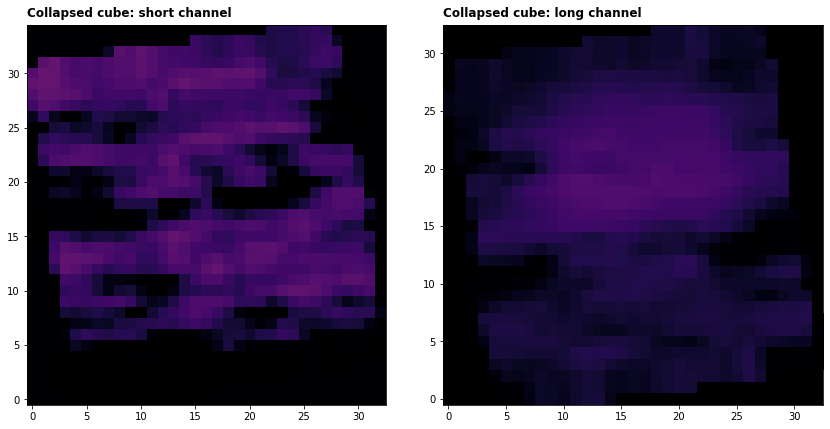

In [12]:
cube_files = sorted(glob.glob(os.path.join(output_dir, 'dither*s3d.fits')))
ch1_cdm = datamodels.open(cube_files[0])
ch2_cdm = datamodels.open(cube_files[1])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(np.sum(ch1_cdm.data[100:-100], axis=0), cmap='inferno', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=1e7))
axs[0].annotate('Collapsed cube: short channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].set_facecolor('black')
axs[1].imshow(np.sum(ch2_cdm.data[100:-100], axis=0), cmap='inferno', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=1e8))
axs[1].annotate('Collapsed cube: long channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].set_facecolor('black')

plt.tight_layout()
plt.show()

2021-03-04 17:43:40,215 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



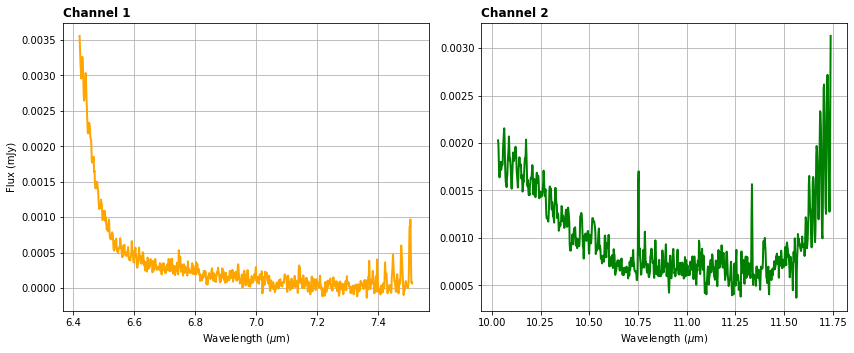

In [13]:
spec_files = sorted(glob.glob(os.path.join(output_dir, 'dither*1d.fits')))
ch1_sdm = datamodels.open(spec_files[0])
ch2_sdm = datamodels.open(spec_files[1])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# plot the spectrum in the channel 2 wavelength range
spaxel_area = ch1_cdm.meta.wcsinfo.cdelt1 * ch1_cdm.meta.wcsinfo.cdelt2 * 3600**2
axs[0].plot(ch1_sdm.spec[0].spec_table['WAVELENGTH'], ch1_sdm.spec[0].spec_table['FLUX'] * spaxel_area, c='orange', marker='.', markersize=0, linestyle='-', linewidth=2)
axs[0].set_ylabel(r'Flux (mJy)')
axs[0].set_xlabel(r'Wavelength ($\mu$m)')
#axs[0].set_xlim(4.9,30)
#axs[0].set_ylim(10,200)

spaxel_area = ch2_cdm.meta.wcsinfo.cdelt1 * ch2_cdm.meta.wcsinfo.cdelt2 * 3600**2
axs[1].plot(ch2_sdm.spec[0].spec_table['WAVELENGTH'], ch2_sdm.spec[0].spec_table['FLUX']  * spaxel_area, c='g', marker='.', markersize=0, linestyle='-', linewidth=2)
axs[1].set_xlabel(r'Wavelength ($\mu$m)')
#axs[1].set_xlim(7.5,8.7)

axs[1].annotate('Channel 2', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].annotate('Channel 1', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].grid()
axs[1].grid()

plt.tight_layout()
plt.show()